In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [3]:
np.random.seed(42)

customers = [f"C{i}" for i in range(1, 101)]
data = []

for customer in customers:
    orders = np.random.randint(1, 10)
    
    for _ in range(orders):
        order_date = datetime.today() - timedelta(days=np.random.randint(1, 365))
        order_amount = np.random.randint(200, 5000)
        data.append([customer, order_date, order_amount])

df = pd.DataFrame(data, columns=["customer_id", "order_date", "order_amount"])
df.head()


,customer_id,order_date,order_amount
0,C1,2025-02-14 23:19:44.826045,3972
1,C1,2026-01-08 23:19:44.826114,666
2,C1,2025-06-28 23:19:44.826140,4626
3,C1,2025-11-02 23:19:44.826159,3644
4,C1,2025-10-21 23:19:44.826177,3119


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   customer_id   500 non-null    object        
 1   order_date    500 non-null    datetime64[ns]
 2   order_amount  500 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 11.8+ KB


In [5]:
reference_date = df["order_date"].max() + timedelta(days=1)


In [6]:
rfm = df.groupby("customer_id").agg({
    "order_date": lambda x: (reference_date - x.max()).days,
    "customer_id": "count",
    "order_amount": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()


,Recency,Frequency,Monetary
customer_id,,,
C1,21,7,17326
C10,96,7,16869
C100,53,3,7912
C11,13,4,9901
C12,121,9,22758


In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


In [8]:
rfm.head()


,Recency,Frequency,Monetary
customer_id,,,
C1,21,7,17326
C10,96,7,16869
C100,53,3,7912
C11,13,4,9901
C12,121,9,22758


In [11]:
rfm.columns


Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


In [13]:
rfm.head()


,Recency,Frequency,Monetary,Cluster
customer_id,,,,
C1,21,7,17326,0
C10,96,7,16869,0
C100,53,3,7912,1
C11,13,4,9901,1
C12,121,9,22758,3


In [14]:
rfm.groupby("Cluster").mean()


,Recency,Frequency,Monetary
Cluster,,,
0,56.611111,6.361111,16035.138889
1,77.236842,2.710526,7671.631579
2,301.142857,1.285714,3442.571429
3,33.947368,8.368421,24147.000000


In [15]:
rfm["Churn"] = rfm["Recency"].apply(lambda x: 1 if x > 90 else 0)
rfm.head()


,Recency,Frequency,Monetary,Cluster,Churn
customer_id,,,,,
C1,21,7,17326,0,0
C10,96,7,16869,0,1
C100,53,3,7912,1,0
C11,13,4,9901,1,0
C12,121,9,22758,3,1


In [16]:
rfm.groupby("Cluster")["Churn"].mean()


Cluster
0    0.222222
1    0.447368
2    1.000000
3    0.052632
Name: Churn, dtype: float64

In [17]:
df["order_month"] = df["order_date"].dt.to_period("M")

cohort = df.groupby("customer_id")["order_month"].min()
df = df.merge(cohort.rename("cohort_month"), on="customer_id")


In [18]:
def month_diff(d1, d2):
    return (d1.year - d2.year) * 12 + (d1.month - d2.month)

df["cohort_index"] = df.apply(
    lambda row: month_diff(row["order_month"].to_timestamp(),
                            row["cohort_month"].to_timestamp()),
    axis=1
)


In [19]:
cohort_data = df.groupby(["cohort_month", "cohort_index"])["customer_id"].nunique().reset_index()

cohort_pivot = cohort_data.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="customer_id"
)

cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

retention


cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2025-01,1.0,0.500000,0.500000,NaN,NaN,0.500000,0.500000,NaN,1.000000,0.500000,NaN,NaN
2025-02,1.0,0.333333,0.200000,0.300000,0.400000,0.400000,0.400000,0.400000,0.533333,0.333333,0.266667,0.333333
2025-03,1.0,0.400000,0.360000,0.360000,0.120000,0.440000,0.320000,0.280000,0.160000,0.480000,0.320000,NaN
2025-04,1.0,0.473684,0.368421,0.526316,0.368421,0.368421,0.315789,0.526316,0.157895,0.368421,NaN,NaN
2025-05,1.0,0.600000,NaN,0.200000,0.200000,0.400000,NaN,0.400000,0.400000,NaN,NaN,NaN
2025-06,1.0,0.500000,0.250000,0.250000,0.250000,0.750000,0.750000,NaN,NaN,NaN,NaN,NaN
2025-07,1.0,0.400000,0.200000,NaN,0.200000,NaN,0.600000,NaN,NaN,NaN,NaN,NaN
2025-08,1.0,0.333333,0.333333,0.333333,0.333333,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
2025-09,1.0,NaN,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


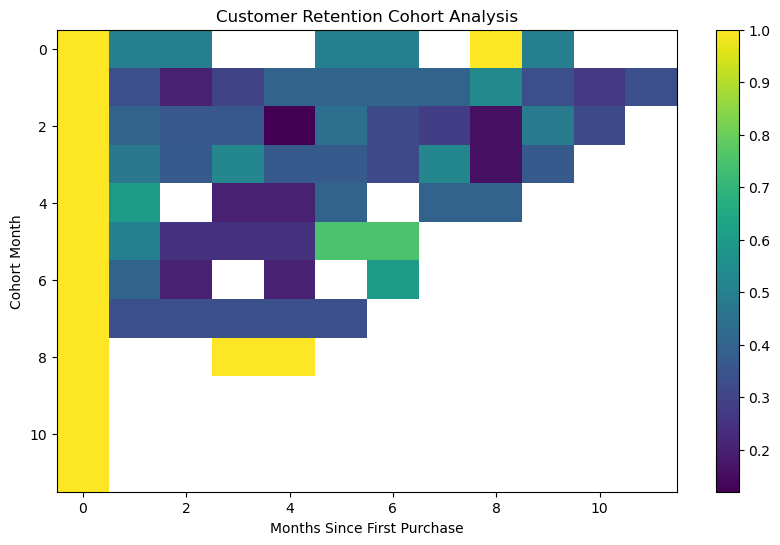

In [20]:
plt.figure(figsize=(10, 6))
plt.imshow(retention, aspect="auto")
plt.colorbar()
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
plt.title("Customer Retention Cohort Analysis")
plt.show()
